# EE 379K: Lab 6

## Rohan Nagar and Wenyang Fu

In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Problem 1: K-Means

### Part 1

Implement the K-Means algorithm with a random initalization. Recall that there are two steps: given the centers, computing the clusters, and given the clusters, computing the centers. As discussed in class, the second is straightforward. Describe how you do the first step.

### Answer

You can do the first step with the following basic algorithm. You have a list of the centers and a list of all the points that need to be put in a cluster.

For each point, compute the distance (using the same distance metric you have been using) from the point to each center. Choose the distance with the smallest magnitude. All of the points with that center as the closest will form a cluster around that center.

In [2]:
# %load kmeans.py
import numpy as np
from collections import defaultdict
from copy import deepcopy


class KMeans(object):
    def __init__(self, df, k):
        """
        Given a pandas dataframe and the of clusters,
        Initializes k-means to its initial K centroids
        via uniform random sampling (without replacement).

        Params:
            df - pandas dataframe containing points to be clustered
            k - number of clusters to form
        """

        # Got some help/inspiration from this StackOverflow link:
        # http://stackoverflow.com/questions/5466323/how-exactly-does-k-means-work
        # Also read this link (a bit confusing, but helpful too):
        # https://datasciencelab.wordpress.com/2014/01/15/improved-seeding-for-clustering-with-k-means/

        self.k = np.min(k, df.shape[0])
        self.points = df.as_matrix()
        self.centers = df.sample(self._k).as_matrix()
        self.clusters = defaultdict(list)

    def _find_center(self, p):
        """ Calculates the closest center for a point based
        on Euclidean distance.

        Args:
            p - a point within self.points

        Returns:
            Index of the center closest to current pixel
        """
        center_dists = np.linalg.norm(p - self.centers, axis=1)
        return np.argmin(center_dists)

    def _assign(self):
        """Assign each point to its nearest centroid."""
        clusters = defaultdict(list)
        for p in self.points:
            center_idx = self._find_center(p)
            clusters[center_idx].append(p)
        self.clusters = clusters

    def update_centroids(self):
        """ Update centroids for a single iteration of k-means."""
        self._assign()
        new_centers = np.zeros(self.centers.shape)
        # Recompute new centroids
        for center_idx, cluster in sorted(self.clusters).items():
            # transform list of points in cluster -> ndarray of points
            cluster_pts = np.array(cluster)
            # Take the average of all points (aka along the rows, axis=0)
            # associated with the current centroid, and
            # use that as the new centroid.
            avg = np.sum(cluster_pts, axis=0) / cluster_pts.shape[0]
            new_centers[center_idx] = avg
        self.centers = new_centers

    def run(self, num_iters=10):
        """
        Runs K-means++ for num_iters iterations, or until
        centroids converge.
        """
        for i in range(num_iters):
            old_centroids = deepcopy(self.centers)
            self.update_centroids()
            if i != 0:
                if self.centers == old_centroids:
                    break
        return zip(self.centers, list(self.clusters.values()))


### Part 2

Now implement K-Means++, i.e., the K-Means++ initalization.

In [3]:
# %load kmeanspp.py
import numpy as np
from collections import defaultdict
from copy import deepcopy


class KMeansPP(object):
    def __init__(self, df, k):
        """
        Given a pandas dataframe and the of clusters,
        Initializes k-means to its initial K centroids
        via k-means++ init

        Params:
            df - pandas dataframe containing points to be clustered
            k - number of clusters to form
        """

        # Got some help/inspiration from this StackOverflow link:
        # http://stackoverflow.com/questions/5466323/how-exactly-does-k-means-work
        # Also read this link (a bit confusing, but helpful too):
        # https://datasciencelab.wordpress.com/2014/01/15/improved-seeding-for-clustering-with-k-means/

        # If the number of points is less than the number
        # of clusters, then set k=number of points
        self.k = min(k, df.shape[0])
        self.points = df.as_matrix()
        self.centers = []

        # Choose initial center uniformly at random from the points.
        c1_index = np.random.randint(low=0, high=self.points.shape[0])
        # self.centers[0] = self.points[c1_index]
        self.centers.append(self.points[c1_index])

        for i in range(1, k):
            # For each iteration, Compute the vector containing the square
            # distances between all points in the dataset

            dist_vec = np.array([min([(c - x) @ (c - x)
                                      for c in self.centers])
                                 for x in self.points])
            # choose each subsequent center from self.points,
            # randomly drawn from the normalized probability distribution
            # over dist_vec.
            probs = dist_vec / dist_vec.sum()
            cumprobs = probs.cumsum()
            r = np.random.rand()

            for j, p in enumerate(cumprobs):
                if r < p:
                    ci_index = j  # Index of every subsequent centroid
                    break
            self.centers.append(self.points[ci_index])

        self.centers = np.array(self.centers)
        self.clusters = defaultdict(list)

    def _find_center(self, p):
        """ Calculates the closest center for a point based
        on Euclidean distance.

        Args:
            p - a point within self.points

        Returns:
            Index of the center closest to current pixel
        """
        center_dists = np.linalg.norm(p - self.centers, axis=1)
        return np.argmin(center_dists)

    def _assign(self):
        """Assign each point to its nearest centroid."""
        clusters = defaultdict(list)
        for p in self.points:
            center_idx = self._find_center(p)
            clusters[center_idx].append(p)
        self.clusters = clusters

    def _update_centroids(self):
        """ Update centroids for a single iteration of k-means."""
        self._assign()
        new_centers = np.zeros(self.centers.shape)
        # Recompute new centroids
        for center_idx, cluster in sorted(self.clusters.items()):
            # transform list of points in cluster -> ndarray of points
            cluster_pts = np.array(cluster)
            # Take the average of all points (aka along the rows, axis=0)
            # associated with the current centroid, and
            # use that as the new centroid.
            avg = np.sum(cluster_pts, axis=0) / cluster_pts.shape[0]
            new_centers[center_idx] = avg
        self.centers = new_centers

    def run(self, num_iters=10):
        """
        Runs K-means++ for num_iters iterations, or until
        centroids converge.
        """
        for i in range(num_iters):
            old_centroids = deepcopy(self.centers)
            self._update_centroids()
            if i != 0:
                if self.centers == old_centroids:
                    break
        return zip(self.centers, list(self.clusters.values()))


### Part 3

Download the data `iris_data.csv` from Canvas. Plot Sepal Width vs. Sepal Length.

In [4]:
iris = pd.read_csv('iris_data.csv')

iris.head()

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
1,5.1,3.5,1.4,0.2,setosa
2,4.9,3.0,1.4,0.2,setosa
3,4.7,3.2,1.3,0.2,setosa
4,4.6,3.1,1.5,0.2,setosa
5,5.0,3.6,1.4,0.2,setosa


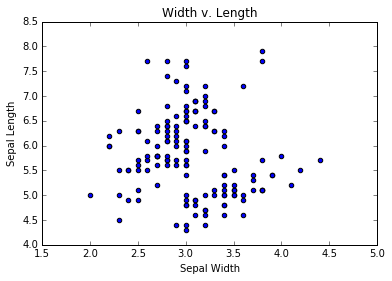

In [5]:
plt.scatter(iris['Sepal.Width'], iris['Sepal.Length'])
plt.title('Width v. Length')
plt.xlabel('Sepal Width')
plt.ylabel('Sepal Length')

In [6]:
iris_X = iris.drop(['Species', 'Petal.Length', 'Petal.Width'], axis=1)
iris_X.head(5)

,Sepal.Length,Sepal.Width
1,5.1,3.5
2,4.9,3.0
3,4.7,3.2
4,4.6,3.1
5,5.0,3.6


### Part 4

Use your K-Means++ algorithm to cluster the above two variables into 2, 3, 4, and 5 clusters.

In [13]:
def show_clusters(clusters, reverse=False):
    fig = plt.figure()
    colors = ['r', 'b', 'g', 'm', 'y']
    for i, cluster in enumerate(list(clusters)):
        _, points = cluster
        # Seperate into x and y
        if not reverse:
            x = [point[1] for point in points]
            y = [point[0] for point in points]
        else:
            x = [point[0] for point in points]
            y = [point[1] for point in points]

        ax1 = fig.add_subplot(2, 1, 1)
        ax1.scatter(x, y, c=colors[i])

    plt.show()

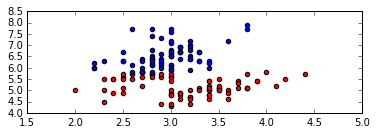

In [27]:
from kmeanspp import KMeansPP

model = KMeansPP(iris_X, 2)
clusters_2 = model.run(num_iters=25)
show_clusters(clusters_2)

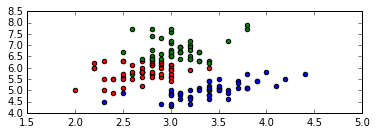

In [28]:
model = KMeansPP(iris_X, 3)
clusters_3 = model.run(num_iters=25)
show_clusters(clusters_3)

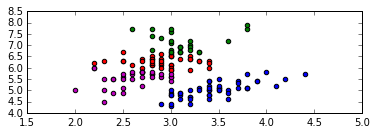

In [29]:
model = KMeansPP(iris_X, 4)
clusters_4 = model.run(num_iters=25)
show_clusters(clusters_4)

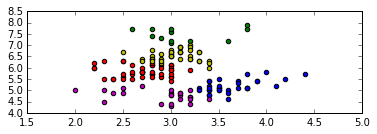

In [30]:
model = KMeansPP(iris_X, 5)
clusters_5 = model.run(num_iters=25)
show_clusters(clusters_5)

# Problem 2: Spectral Clustering

Spectral clustering, as described in class, is a powerful and much-used algorithm. A very in-depth tutorial can be found here: http://www.cs.cmu.edu/~aarti/Class/10701/readings/Luxburg06_TR.pdf. In class we discussed the application of spectral clustering to a given graph. But we can also apply it to other data sets, by turning them into weighted graphs. This can be done in several ways, but roughly speaking, we convert by means of a similarity function: two nodes have an edge between them with weight equal to their similiarity. Read section 2 of the above tutorial on different ways to create the similiarity graph. Then read section 4 on the different graph clustering algorithms, especically focusing on the one by Ng, Jordan and Weiss (2002). This is the one we discussed in class.

### Part 1

Implement the Ng, Jordan and Weiss spectral clustering algorithm. You may use basic linear algebra functions, including SVD and eigenvalue decomposition, but do not use `sklearn.cluster.spectral.clustering` or anything similar. Of course, you can use your K-Means algorithm from above for the last step.

In [12]:
def spectral_cluster(sim_graph, k):
    # Compute L_sym
    L_sym = [[1, 1, 1], [1, 1, 1], [2, 2, 4]]
    
    # Find first k eigenvectors of L_sym
    evals, evects = np.linalg.eig(L_sym)
    
    # TODO...
    
spectral_cluster(None, None)

### Part 2

Write a program that generates N data points uniformly at random on two concentric rings, and then add two-dimensional Gaussian noise of variance $\sigma_1^2$ and $\sigma_2^2$ to each point. There are four parameters of interest here: the number of points, the difference in the radii of the two rings, the amount (the variance) of noise added to the internal ring, and the amount of noise added to the external ring.

### Part 3

Experiement with the 3 methods of creating similarity functions described in section 2 of the paper. Pick one that you like (clearly state which one), and fixing $N = 500$ and $\sigma_1 = \sigma_2 = 1$, and also the radius of the inner ring to be $1$, find the range of the outer ring radius for which spectral clustering, using your chosen similarity function, succeeds in clustering the two different rings. Note that you will be using $k = 2$ in your spectral clustering algorithm.

# Problem 3: Spectral Clustering vs. K-Means

### Part 1

Load the data from the two-dimenstional `two_moons.csv` and the three-dimensional `linked_chains.csv`. Each row represents a point. Note that the first column gives the ground truth - the cluster identity of each point - and so can be ignored. Plot each in 2d and 3d respectively, so you can see what is going on. 

In [14]:
moons = pd.read_csv('two_moons.csv', header=None)
moons.head()

,0,1,2
0,2,0.250844,-0.001121
1,2,0.221185,0.008294
2,2,0.257351,-0.052437
3,2,0.197335,-0.030503
4,2,0.256422,-0.019958


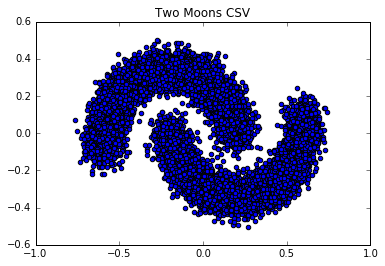

In [15]:
plt.scatter(moons[1], moons[2])
plt.title('Two Moons CSV')

In [16]:
chains = pd.read_csv('linked_chains.csv', header=None)
chains.head()

,0,1,2,3
0,1,-0.424914,-0.879778,0.019944
1,1,0.609164,-0.851496,0.018148
2,1,0.370662,0.258447,-0.002878
3,1,0.087514,0.347741,0.004298
4,1,0.488615,-0.911575,0.033750


/Users/rohannagar/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


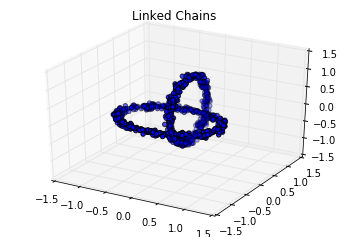

In [17]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(chains[1], chains[2], chains[3], label='Linked Chains')
plt.title('Linked Chains')
fig.show()

### Part 2

Run K-Means on both. How do you do?

In [18]:
moons_X = moons.drop(0, axis=1)
moons_X.head()

,1,2
0,0.250844,-0.001121
1,0.221185,0.008294
2,0.257351,-0.052437
3,0.197335,-0.030503
4,0.256422,-0.019958


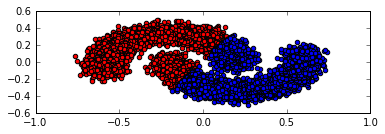

In [24]:
model = KMeansPP(moons_X, 2)
moon_clusters = model.run(num_iters=20)
show_clusters(moon_clusters, reverse=True)

Clearly, K-Means does not do a very good job clustering the Moons dataset.

In [20]:
chains_X = chains.drop(0, axis=1)
chains_X.head()

,1,2,3
0,-0.424914,-0.879778,0.019944
1,0.609164,-0.851496,0.018148
2,0.370662,0.258447,-0.002878
3,0.087514,0.347741,0.004298
4,0.488615,-0.911575,0.033750


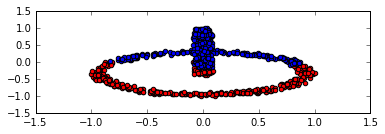

In [25]:
model = KMeansPP(chains_X, 2)
chain_clusters = model.run(num_iters=20)
show_clusters(chain_clusters, reverse=True)

Again, based on this plot we can see that K-Means doesn't do a good job of clustering the chains. The clusters were done in 3D but the plot is shown in 2D.

### Part 3

Find the best similarity function you can, and run Spectral Clustering. Which is better?

In [22]:
model = SpectralCluster(moons_X, 2)
moon_clusters_spectral = model.run()
show_clusters(moon_clusters_spectral, reverse=True)

NameError: name 'SpectralCluster' is not defined

In [23]:
model = SpectralCluster(chains_X, 2)
chain_clusters_spectral = model.run()
show_clusters(chain_clusters_spectral, reverse=True)

NameError: name 'SpectralCluster' is not defined

# Problem 4: More Spectral Clustering vs. K-Means

### Part 1

Generate an example where K-Means does better than Spectral Clustering. Explain how you constructed it and why, in addition to showing the plots.

# Problem 5: Computational Complexity and Spectral Clustering

### Part 1

This is a more open ended question. Computing the eigenvalues and eigenvectors of a matrix is not easy, and the complexity depends on the size of the matrix among other factors. An important factor is the sparsity of the matrix. Which aspects of your algorithm for spectral clustering could affect this? Using one of the examples from above, or another example of your choosing, try to illustrate this pheonomeon.